# Description 1 -- Original

In [ ]:
from __future__ import annotations
import os, re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity

# ===== Paths =====
RESUME_CSV = "/content/resumes_latest_ver (1) (1).csv"
OUTPUT_CSV = "/content/sample_data/rank_resumes_1.csv"

# ===== Weights =====
w_hard = 0.5   # how strongly hard skill keyword match drives the scores
w_exp  = 0.3   # weight for job experience (years + job count)

# ===== Java JD (still useful context, but ranking is keyword-based now) =====
JAVA_DEV_JD = (
    "Responsibilities of the Java Developer include Develop and maintain business applications and backend services using Java (Spring Boot) and SQL Server."
    "Create and optimize SQL queries, stored procedures, and other database operations. "
    "Collaborate with cross-functional teams to analyze feature requests, design solutions, and deliver new application functionality. "
    "Build and maintain REST APIs to support middle-tier web services. "
    "Perform batch processing, scheduled jobs, and interface setup for file selection and delivery. "
    "Conduct refactor work to modernize and improve code quality. "
    "Troubleshoot and resolve bugs/maintenance issues. "
    "Participate in CI/CD processes, code reviews, and version control best practices. "
    "Preferred Experience of the Java Developer includes over 5 years of professional software development experience. "
    "Strong proficiency with Java (Spring Boot preferred; C# experience may be considered). "
    "Expertise in SQL Server (queries, stored procedures, performance optimization). "
    "Experience with front-end visualization frameworks (Vue or Ember preferred). "
    "Proven experience developing and integrating REST APIs."
)


# ===== Keyword groups =====
preferred_years_threshold = 5.0
w_hard_required = 0.5
w_hard_preferred = 0.25

w_soft = 0.2   # weight for soft skills keyword match

w_pref_kw_bonus  = 0.75
w_pref_exp_bonus = 0.25

HARD_REQUIRED_KEYWORDS = [
    "java",
    "spring", "spring boot", "springboot",
    "sql", "sql server",
    "stored procedure", "stored procedures",
    "rest", "rest api", "restful",
    "ci/cd", "continuous integration", "continuous deployment",
    "git", "version control",
    "code review", "code reviews",
]

HARD_PREFERRED_KEYWORDS = [
    "c#", "csharp",
    "vue", "ember",
    "performance optimization", "indexing", "t-sql", "tsql",
    "batch processing", "scheduled job", "scheduled jobs", "scheduler", "cron",
    "refactor", "refactoring", "code quality",
    "troubleshoot", "debug", "maintenance",
    "microservice", "microservices", "hibernate", "jpa",
    "maven", "gradle",
    "junit", "unit test", "unit testing", "testng",
    "github", "gitlab",
]

SOFT_SKILLS_KEYWORDS = [

    "collaborate",
    "collaboration",
    "cross-functional",
    "cross functional",
    "work with teams",
    "troubleshoot",
    "resolve"

]

# Note: "experience" is handled via years/jobs numeric columns,
# not from text, to avoid fabricating data.

# ===== Helpers =====

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"https?:\/\/\S+", " ", t)
    t = t.replace("C++", " CppPlus ").replace("c++", " CppPlus ")
    t = t.replace("C#", " Csharp ").replace("c#", " Csharp ")
    t = t.replace(".NET", " dotnet ")
    t = re.sub(r"[^A-Za-z0-9\s\+#]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    t = t.replace("cppplus", "c++").replace("csharp", "c#")
    return t


def detect_text_column(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    preferred = ["resume", "resume_text", "text", "content", "summary", "profile", "description"]
    for name in preferred:
        for c in df.columns:
            if c.lower() == name:
                return c, df[c].astype(str)
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        return "_auto_concat", df.astype(str).agg(" ".join, axis=1)
    avg_lens = {c: df[c].astype(str).str.len().mean() for c in text_cols}
    best = max(avg_lens, key=avg_lens.get)
    return best, df[best].astype(str)


def detect_id_column(df: pd.DataFrame) -> Optional[str]:
    for name in ["candidate_id", "id", "name", "candidate", "user_id"]:
        for c in df.columns:
            if c.lower() == name:
                return c
    return None


def safe_to_float(series: pd.Series) -> np.ndarray:
    def parse_value(x):
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            x2 = x.replace("+", "").strip()
            try:
                return float(x2)
            except ValueError:
                return np.nan
        return np.nan
    arr = series.apply(parse_value).astype(float).to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)
    return arr


def minmax(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return x
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return (x - lo) / (hi - lo)


def keyword_match_score(text: str, keywords: List[str]) -> int: # counts how many distinct keywords appear at least once
    cleaned = _clean_text(text)
    score = 0
    for kw in keywords:
        kw_clean = kw.lower().strip()
        if not kw_clean:
            continue
        kw_pattern = re.escape(kw_clean).replace(r"\ ", r"[\s\-]+")
        pattern = r"(?<!\w)" + kw_pattern + r"(?!\w)"
        if re.search(pattern, cleaned):
            score +=1
    return score


# ===== Main =====

def main():
    if not os.path.exists(RESUME_CSV):
        raise FileNotFoundError(f"CSV not found at {RESUME_CSV}")

    df = pd.read_csv(RESUME_CSV)

    # Text and IDs
    id_col = detect_id_column(df)
    txt_col, series = detect_text_column(df)
    resumes = series.fillna("").astype(str).tolist()

    # === Experience from numeric columns (years & jobs) ===
    exp_col = None
    for c in df.columns:
        cl = c.lower()
        if ("year" in cl and "experience" in cl) or cl in {
            "years", "experience_years", "years_of_experience"
        }:
            exp_col = c
            break

    jobs_col = None
    for c in df.columns:
        cl = c.lower()
        if ("job" in cl and ("count" in cl or "number" in cl or "past" in cl)) or cl in {
            "jobs", "job_count", "number_of_jobs"
        }:
            jobs_col = c
            break

    # Use them if present; otherwise 0
    exp_vals = safe_to_float(df[exp_col]) if exp_col is not None else np.zeros(len(df), dtype=float)
    jobs_vals = safe_to_float(df[jobs_col]) if jobs_col is not None else np.zeros(len(df), dtype=float)

    exp_norm = minmax(exp_vals)
    jobs_norm = minmax(jobs_vals)

    # general experience score
    experience_score = 0.6 * exp_norm + 0.4 * jobs_norm

    # === Preferred experience bonus ===
    preferred_years_bonus = (exp_vals >= preferred_years_threshold).astype(float)

    # === Keyword-based hard & soft skill scores ===
    hard_required_raw = np.array([keyword_match_score(t, HARD_REQUIRED_KEYWORDS) for t in resumes], dtype=float)
    hard_preferred_kw_raw = np.array([keyword_match_score(t, HARD_PREFERRED_KEYWORDS) for t in resumes], dtype=float)

    hard_required_norm = minmax(hard_required_raw)
    hard_preferred_kw_norm = minmax(hard_preferred_kw_raw)

    hard_preferred_norm = (
        w_pref_kw_bonus * hard_preferred_kw_norm
        + w_pref_exp_bonus * preferred_years_bonus
    )
    # Total hard skills score
    hard_norm = (
        w_hard_required * hard_required_norm
        + w_hard_preferred * hard_preferred_norm
    )

    # === Soft skills ===
    soft_skill_raw = np.array([keyword_match_score(t, SOFT_SKILLS_KEYWORDS) for t in resumes], dtype=float)
    soft_norm = minmax(soft_skill_raw)

    # === Final score ===
    final_score = (
        w_hard * hard_norm
        + w_soft * soft_norm
        + w_exp  * experience_score
    )


    # Assemble output
    out = pd.DataFrame({
        "candidate_id": df[id_col] if id_col else np.arange(len(df)),
        # Raw keyword counts
        "hard_required_keyword_raw": hard_required_raw,
        "hard_preferred_keyword_raw": hard_preferred_kw_raw,
        "soft_skill_keyword_raw": soft_skill_raw,
        # Normalized components
        "hard_required_score": hard_required_norm,
        "hard_preferred_kw_score": hard_preferred_kw_norm,
        "preferred_years_bonus_5plus": preferred_years_bonus,
        "hard_preferred_score": hard_preferred_norm,
        "hard_skill_score": hard_norm,

        "soft_skill_score": soft_norm,
        "experience_years_norm": exp_norm,
        "experience_jobs_norm": jobs_norm,
        "experience_score": experience_score,
        # Final ranking
        "final_score": final_score,
        "rank_final": pd.Series(final_score).rank(ascending=False, method="dense").astype(int),
    })

    # Echo original numeric experience columns if present
    if exp_col is not None:
        out[exp_col] = df[exp_col]
    if jobs_col is not None:
        out[jobs_col] = df[jobs_col]

    # Pass through gender if present
    for c in df.columns:
        if c.lower() == "gender":
            out["gender"] = df[c]
            break

    out = out.sort_values(["rank_final", "candidate_id"]).reset_index(drop=True)

    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out.to_csv(OUTPUT_CSV, index=False)

    print("CSV:", RESUME_CSV)
    print("Text column:", txt_col)
    print("ID column:", id_col if id_col else "(index)")
    print("Experience column:", exp_col if exp_col else "(not found)")
    print("Jobs column:", jobs_col if jobs_col else "(not found)")
    print("Saved to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()


CSV: /content/resumes_latest_ver (1) (1).csv
Text column: Summary
ID column: (index)
Experience column: Years of Experience
Jobs column: Number of Past Jobs
Saved to: /content/sample_data/rank_resumes_1.csv


In [ ]:
data1 = pd.read_csv("/content/sample_data/rank_resumes_1.csv")
top_50_percent_applicants = data1.nlargest(int(0.5 * len(data1)), 'final_score')

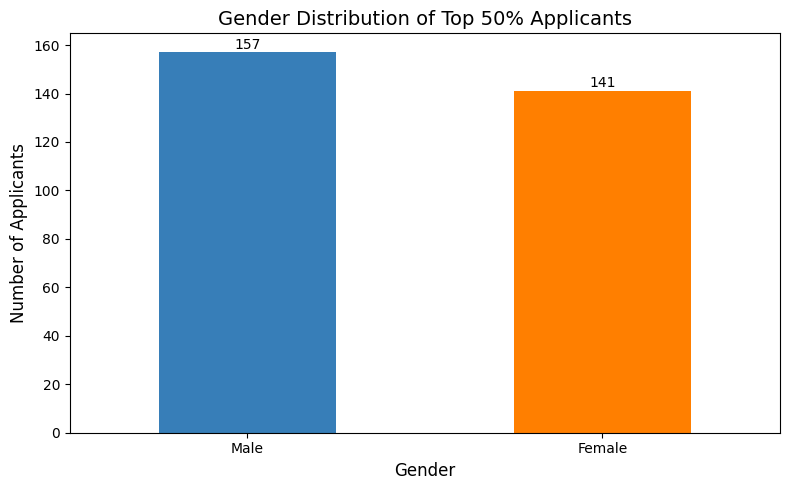

In [ ]:
import matplotlib.pyplot as plt

gender_distribution_top_50 = top_50_percent_applicants['gender'].value_counts()

plt.figure(figsize=(8, 5))
gender_distribution_top_50.plot(kind='bar', color=['#377eb8', '#ff7f00'])

plt.title("Gender Distribution of Top 50% Applicants", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)
plt.xticks(rotation=0)

for i, count in enumerate(gender_distribution_top_50):
    plt.text(i, count + (0.01 * gender_distribution_top_50.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Description 2 -- Injected Masculine

In [ ]:
from __future__ import annotations
import os, re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity

# ===== Paths =====
RESUME_CSV = "/content/resumes_latest_ver (1) (1).csv"
OUTPUT_CSV = "/content/sample_data/rank_resumes_2.csv"

# ===== Weights =====
w_hard = 0.5   # how strongly hard skill keyword match drives the scores
w_exp  = 0.3   # weight for job experience (years + job count)

# ===== Java JD (still useful context, but ranking is keyword-based now) =====
JAVA_DEV_JD = (
    "Responsibilities of the Java Developer include Develop and maintain high-performance business applications and backend services using Java (Spring Boot) and SQL Server."
    "Engineer optimized SQL queries, stored procedures, and database operations for maximum efficiency."
    "Work with cross-functional teams to evaluate feature requests, design strong technical solutions, and deliver new system capabilities."
    "Build and maintain robust REST APIs to support critical middle-tier services."
    "Execute batch processing, scheduled jobs, and interface setups for efficient file movement and delivery."
    "Lead refactoring initiatives to modernize systems and strengthen overall code quality."
    "Diagnose, troubleshoot, and resolve complex bugs and maintenance issues."
    "Take an active role in CI/CD processes, code reviews, and enforcing version-control best practices."
    "Preferred Experience of the Java Developer includes over 5 years of professional software development experience, demonstrating strong technical expertise and ownership."
    "Deep proficiency with Java (Spring Boot preferred; C# experience may also be considered)."
    "Advanced expertise in SQL Server, including performance tuning and complex query design."
    "Experience with modern front-end visualization frameworks (Vue or Ember preferred)."
    "Proven ability to design, develop, and integrate scalable REST APIs."
)


# ===== Keyword groups =====
preferred_years_threshold = 5.0
w_hard_required = 0.5
w_hard_preferred = 0.25

w_soft = 0.2   # weight for soft skills keyword match

w_pref_kw_bonus  = 0.75
w_pref_exp_bonus = 0.25

HARD_REQUIRED_KEYWORDS = [
    "java",
    "spring", "spring boot", "springboot",
    "sql", "sql server",
    "stored procedure", "stored procedures",
    "rest", "rest api", "restful",
    "ci/cd", "continuous integration", "continuous deployment",
    "git", "version control",
    "code review", "code reviews",
]

HARD_PREFERRED_KEYWORDS = [
    # frontend (explicitly preferred)
    "vue", "ember",
    # alternative / considered language
    "c#", "csharp",

    "performance tuning", "performance optimization", "complex queries",
    "refactor", "refactoring",
    "code quality", "modernization",

    "diagnose", "troubleshoot", "debug", "maintenance",

    "batch processing",
    "scheduled job", "scheduled jobs",
    "interface setup",
    "file movement", "file delivery"

]

SOFT_SKILLS_KEYWORDS = [
    # collaboration
    "collaborate", "collaboration", "cross-functional", "cross functional", "work with teams", "troubleshoot", "resolve"

    # delivery & execution
    "efficient", "efficiency", "maximum", "execute", "deliver", "delivery", "implementation"

    # leadership
    "lead", "leadership", "initiative", "active", "active role", "ownership"

    # problem resolution
    "diagnose", "troubleshoot", "resolve"

    # quality & reliability
    "code quality", "best practices", "maintain", "maintenance"

    # evaluation & design thinking
    "evaluate", "analysis", "analyze", "design", "design solutions", "technical solutions"

]

# Note: "experience" is handled via years/jobs numeric columns,
# not from text, to avoid fabricating data.

# ===== Helpers =====

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"https?:\/\/\S+", " ", t)
    t = t.replace("C++", " CppPlus ").replace("c++", " CppPlus ")
    t = t.replace("C#", " Csharp ").replace("c#", " Csharp ")
    t = t.replace(".NET", " dotnet ")
    t = re.sub(r"[^A-Za-z0-9\s\+#]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    t = t.replace("cppplus", "c++").replace("csharp", "c#")
    return t


def detect_text_column(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    preferred = ["resume", "resume_text", "text", "content", "summary", "profile", "description"]
    for name in preferred:
        for c in df.columns:
            if c.lower() == name:
                return c, df[c].astype(str)
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        return "_auto_concat", df.astype(str).agg(" ".join, axis=1)
    avg_lens = {c: df[c].astype(str).str.len().mean() for c in text_cols}
    best = max(avg_lens, key=avg_lens.get)
    return best, df[best].astype(str)


def detect_id_column(df: pd.DataFrame) -> Optional[str]:
    for name in ["candidate_id", "id", "name", "candidate", "user_id"]:
        for c in df.columns:
            if c.lower() == name:
                return c
    return None


def safe_to_float(series: pd.Series) -> np.ndarray:
    def parse_value(x):
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            x2 = x.replace("+", "").strip()
            try:
                return float(x2)
            except ValueError:
                return np.nan
        return np.nan
    arr = series.apply(parse_value).astype(float).to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)
    return arr


def minmax(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return x
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return (x - lo) / (hi - lo)


def keyword_match_score(text: str, keywords: List[str]) -> int: # counts how many distinct keywords appear at least once
    cleaned = _clean_text(text)
    score = 0
    for kw in keywords:
        kw_clean = kw.lower().strip()
        if not kw_clean:
            continue
        kw_pattern = re.escape(kw_clean).replace(r"\ ", r"[\s\-]+")
        pattern = r"(?<!\w)" + kw_pattern + r"(?!\w)"
        if re.search(pattern, cleaned):
            score +=1
    return score


# ===== Main =====

def main():
    if not os.path.exists(RESUME_CSV):
        raise FileNotFoundError(f"CSV not found at {RESUME_CSV}")

    df = pd.read_csv(RESUME_CSV)

    # Text and IDs
    id_col = detect_id_column(df)
    txt_col, series = detect_text_column(df)
    resumes = series.fillna("").astype(str).tolist()

    # === Experience from numeric columns (years & jobs) ===
    exp_col = None
    for c in df.columns:
        cl = c.lower()
        if ("year" in cl and "experience" in cl) or cl in {
            "years", "experience_years", "years_of_experience"
        }:
            exp_col = c
            break

    jobs_col = None
    for c in df.columns:
        cl = c.lower()
        if ("job" in cl and ("count" in cl or "number" in cl or "past" in cl)) or cl in {
            "jobs", "job_count", "number_of_jobs"
        }:
            jobs_col = c
            break

    # Use them if present; otherwise 0
    exp_vals = safe_to_float(df[exp_col]) if exp_col is not None else np.zeros(len(df), dtype=float)
    jobs_vals = safe_to_float(df[jobs_col]) if jobs_col is not None else np.zeros(len(df), dtype=float)

    exp_norm = minmax(exp_vals)
    jobs_norm = minmax(jobs_vals)

    # general experience score
    experience_score = 0.6 * exp_norm + 0.4 * jobs_norm

    # === Preferred experience bonus ===
    preferred_years_bonus = (exp_vals >= preferred_years_threshold).astype(float)

    # === Keyword-based hard & soft skill scores ===
    hard_required_raw = np.array([keyword_match_score(t, HARD_REQUIRED_KEYWORDS) for t in resumes], dtype=float)
    hard_preferred_kw_raw = np.array([keyword_match_score(t, HARD_PREFERRED_KEYWORDS) for t in resumes], dtype=float)

    hard_required_norm = minmax(hard_required_raw)
    hard_preferred_kw_norm = minmax(hard_preferred_kw_raw)

    hard_preferred_norm = (
        w_pref_kw_bonus * hard_preferred_kw_norm
        + w_pref_exp_bonus * preferred_years_bonus
    )
    # Total hard skills score
    hard_norm = (
        w_hard_required * hard_required_norm
        + w_hard_preferred * hard_preferred_norm
    )

    # === Soft skills ===
    soft_skill_raw = np.array([keyword_match_score(t, SOFT_SKILLS_KEYWORDS) for t in resumes], dtype=float)
    soft_norm = minmax(soft_skill_raw)

    # === Final score ===
    final_score = (
        w_hard * hard_norm
        + w_soft * soft_norm
        + w_exp  * experience_score
    )


    # Assemble output
    out = pd.DataFrame({
        "candidate_id": df[id_col] if id_col else np.arange(len(df)),
        # Raw keyword counts
        "hard_required_keyword_raw": hard_required_raw,
        "hard_preferred_keyword_raw": hard_preferred_kw_raw,
        "soft_skill_keyword_raw": soft_skill_raw,
        # Normalized components
        "hard_required_score": hard_required_norm,
        "hard_preferred_kw_score": hard_preferred_kw_norm,
        "preferred_years_bonus_5plus": preferred_years_bonus,
        "hard_preferred_score": hard_preferred_norm,
        "hard_skill_score": hard_norm,

        "soft_skill_score": soft_norm,
        "experience_years_norm": exp_norm,
        "experience_jobs_norm": jobs_norm,
        "experience_score": experience_score,
        # Final ranking
        "final_score": final_score,
        "rank_final": pd.Series(final_score).rank(ascending=False, method="dense").astype(int),
    })

    # Echo original numeric experience columns if present
    if exp_col is not None:
        out[exp_col] = df[exp_col]
    if jobs_col is not None:
        out[jobs_col] = df[jobs_col]

    # Pass through gender if present
    for c in df.columns:
        if c.lower() == "gender":
            out["gender"] = df[c]
            break

    out = out.sort_values(["rank_final", "candidate_id"]).reset_index(drop=True)

    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out.to_csv(OUTPUT_CSV, index=False)

    print("CSV:", RESUME_CSV)
    print("Text column:", txt_col)
    print("ID column:", id_col if id_col else "(index)")
    print("Experience column:", exp_col if exp_col else "(not found)")
    print("Jobs column:", jobs_col if jobs_col else "(not found)")
    print("Saved to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()


CSV: /content/resumes_latest_ver (1) (1).csv
Text column: Summary
ID column: (index)
Experience column: Years of Experience
Jobs column: Number of Past Jobs
Saved to: /content/sample_data/rank_resumes_2.csv


In [ ]:
data2 = pd.read_csv("/content/sample_data/rank_resumes_2.csv")
top_50_percent_applicants = data2.nlargest(int(0.5 * len(data2)), 'final_score')

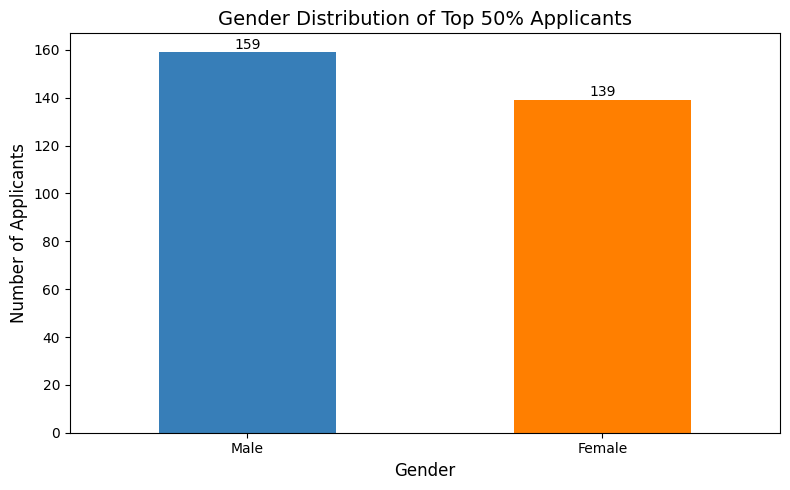

In [ ]:
import matplotlib.pyplot as plt

gender_distribution_top_50 = top_50_percent_applicants['gender'].value_counts()

plt.figure(figsize=(8, 5))
gender_distribution_top_50.plot(kind='bar', color=['#377eb8', '#ff7f00'])

plt.title("Gender Distribution of Top 50% Applicants", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)
plt.xticks(rotation=0)

for i, count in enumerate(gender_distribution_top_50):
    plt.text(i, count + (0.01 * gender_distribution_top_50.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Description 3 -- Injected Feminine

In [59]:
from __future__ import annotations
import os, re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity

# ===== Paths =====
RESUME_CSV = "/content/resumes_latest_ver (1) (1).csv"
OUTPUT_CSV = "/content/sample_data/rank_resumes_3.csv"

# ===== Weights =====
w_hard = 0.5   # how strongly hard skill keyword match drives the scores
w_exp  = 0.3   # weight for job experience (years + job count)

# ===== Java JD (still useful context, but ranking is keyword-based now) =====
JAVA_DEV_JD = (
    "Responsibilities of the Java Developer include Develop and maintain high-performance business applications and backend services using Java (Spring Boot) and SQL Server."
    "Engineer optimized SQL queries, stored procedures, and database operations for maximum efficiency."
    "Work with cross-functional teams to evaluate feature requests, design strong technical solutions, and deliver new system capabilities."
    "Build and maintain robust REST APIs to support critical middle-tier services."
    "Execute batch processing, scheduled jobs, and interface setups for efficient file movement and delivery."
    "Lead refactoring initiatives to modernize systems and strengthen overall code quality."
    "Diagnose, troubleshoot, and resolve complex bugs and maintenance issues."
    "Take an active role in CI/CD processes, code reviews, and enforcing version-control best practices."
    "Preferred Experience of the Java Developer includes over 5 years of professional software development experience, demonstrating strong technical expertise and ownership."
    "Deep proficiency with Java (Spring Boot preferred; C# experience may also be considered)."
    "Advanced expertise in SQL Server, including performance tuning and complex query design."
    "Experience with modern front-end visualization frameworks (Vue or Ember preferred)."
    "Proven ability to design, develop, and integrate scalable REST APIs."
)


# ===== Keyword groups =====
preferred_years_threshold = 5.0
w_hard_required = 0.5
w_hard_preferred = 0.25

w_soft = 0.2   # weight for soft skills keyword match

w_pref_kw_bonus  = 0.75
w_pref_exp_bonus = 0.25

HARD_REQUIRED_KEYWORDS = [
    "java",
    "spring", "spring boot", "springboot",
    "sql", "sql server",
    "stored procedure", "stored procedures",
    "rest", "rest api", "restful",
    "ci/cd", "continuous integration", "continuous deployment",
    "git", "version control",
    "code review", "code reviews",
]

HARD_PREFERRED_KEYWORDS = [
    # frontend (explicitly preferred)
    "vue", "ember",
    # alternative / considered language
    "c#", "csharp",

    "performance tuning", "performance optimization", "complex queries",
    "refactor", "refactoring",
    "code quality", "modernization",

    "diagnose", "troubleshoot", "debug", "maintenance",

    "batch processing",
    "scheduled job", "scheduled jobs",
    "interface setup",
    "file movement", "file delivery"

]

SOFT_SKILLS_KEYWORDS = [
    # collaboration
    "collaborate", "collaboration", "cross-functional", "cross functional", "work with teams", "troubleshoot", "resolve"

    # support & teamwork
    "connect", "support", "discuss", "assist", "understand", "enhance", "contribute",
    "participate", "help", "gently", "supportive", "supportive", "team mindset",


    # problem resolution
    "diagnose", "troubleshoot", "resolve", "build", "maintain"

]

# Note: "experience" is handled via years/jobs numeric columns,
# not from text, to avoid fabricating data.

# ===== Helpers =====

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"https?:\/\/\S+", " ", t)
    t = t.replace("C++", " CppPlus ").replace("c++", " CppPlus ")
    t = t.replace("C#", " Csharp ").replace("c#", " Csharp ")
    t = t.replace(".NET", " dotnet ")
    t = re.sub(r"[^A-Za-z0-9\s\+#]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    t = t.replace("cppplus", "c++").replace("csharp", "c#")
    return t


def detect_text_column(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    preferred = ["resume", "resume_text", "text", "content", "summary", "profile", "description"]
    for name in preferred:
        for c in df.columns:
            if c.lower() == name:
                return c, df[c].astype(str)
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        return "_auto_concat", df.astype(str).agg(" ".join, axis=1)
    avg_lens = {c: df[c].astype(str).str.len().mean() for c in text_cols}
    best = max(avg_lens, key=avg_lens.get)
    return best, df[best].astype(str)


def detect_id_column(df: pd.DataFrame) -> Optional[str]:
    for name in ["candidate_id", "id", "name", "candidate", "user_id"]:
        for c in df.columns:
            if c.lower() == name:
                return c
    return None


def safe_to_float(series: pd.Series) -> np.ndarray:
    def parse_value(x):
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            x2 = x.replace("+", "").strip()
            try:
                return float(x2)
            except ValueError:
                return np.nan
        return np.nan
    arr = series.apply(parse_value).astype(float).to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)
    return arr


def minmax(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return x
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return (x - lo) / (hi - lo)


def keyword_match_score(text: str, keywords: List[str]) -> int: # counts how many distinct keywords appear at least once
    cleaned = _clean_text(text)
    score = 0
    for kw in keywords:
        kw_clean = kw.lower().strip()
        if not kw_clean:
            continue
        kw_pattern = re.escape(kw_clean).replace(r"\ ", r"[\s\-]+")
        pattern = r"(?<!\w)" + kw_pattern + r"(?!\w)"
        if re.search(pattern, cleaned):
            score +=1
    return score


# ===== Main =====

def main():
    if not os.path.exists(RESUME_CSV):
        raise FileNotFoundError(f"CSV not found at {RESUME_CSV}")

    df = pd.read_csv(RESUME_CSV)

    # Text and IDs
    id_col = detect_id_column(df)
    txt_col, series = detect_text_column(df)
    resumes = series.fillna("").astype(str).tolist()

    # === Experience from numeric columns (years & jobs) ===
    exp_col = None
    for c in df.columns:
        cl = c.lower()
        if ("year" in cl and "experience" in cl) or cl in {
            "years", "experience_years", "years_of_experience"
        }:
            exp_col = c
            break

    jobs_col = None
    for c in df.columns:
        cl = c.lower()
        if ("job" in cl and ("count" in cl or "number" in cl or "past" in cl)) or cl in {
            "jobs", "job_count", "number_of_jobs"
        }:
            jobs_col = c
            break

    # Use them if present; otherwise 0
    exp_vals = safe_to_float(df[exp_col]) if exp_col is not None else np.zeros(len(df), dtype=float)
    jobs_vals = safe_to_float(df[jobs_col]) if jobs_col is not None else np.zeros(len(df), dtype=float)

    exp_norm = minmax(exp_vals)
    jobs_norm = minmax(jobs_vals)

    # general experience score
    experience_score = 0.6 * exp_norm + 0.4 * jobs_norm

    # === Preferred experience bonus ===
    preferred_years_bonus = (exp_vals >= preferred_years_threshold).astype(float)

    # === Keyword-based hard & soft skill scores ===
    hard_required_raw = np.array([keyword_match_score(t, HARD_REQUIRED_KEYWORDS) for t in resumes], dtype=float)
    hard_preferred_kw_raw = np.array([keyword_match_score(t, HARD_PREFERRED_KEYWORDS) for t in resumes], dtype=float)

    hard_required_norm = minmax(hard_required_raw)
    hard_preferred_kw_norm = minmax(hard_preferred_kw_raw)

    hard_preferred_norm = (
        w_pref_kw_bonus * hard_preferred_kw_norm
        + w_pref_exp_bonus * preferred_years_bonus
    )
    # Total hard skills score
    hard_norm = (
        w_hard_required * hard_required_norm
        + w_hard_preferred * hard_preferred_norm
    )

    # === Soft skills ===
    soft_skill_raw = np.array([keyword_match_score(t, SOFT_SKILLS_KEYWORDS) for t in resumes], dtype=float)
    soft_norm = minmax(soft_skill_raw)

    # === Final score ===
    final_score = (
        w_hard * hard_norm
        + w_soft * soft_norm
        + w_exp  * experience_score
    )


    # Assemble output
    out = pd.DataFrame({
        "candidate_id": df[id_col] if id_col else np.arange(len(df)),
        # Raw keyword counts
        "hard_required_keyword_raw": hard_required_raw,
        "hard_preferred_keyword_raw": hard_preferred_kw_raw,
        "soft_skill_keyword_raw": soft_skill_raw,
        # Normalized components
        "hard_required_score": hard_required_norm,
        "hard_preferred_kw_score": hard_preferred_kw_norm,
        "preferred_years_bonus_5plus": preferred_years_bonus,
        "hard_preferred_score": hard_preferred_norm,
        "hard_skill_score": hard_norm,

        "soft_skill_score": soft_norm,
        "experience_years_norm": exp_norm,
        "experience_jobs_norm": jobs_norm,
        "experience_score": experience_score,
        # Final ranking
        "final_score": final_score,
        "rank_final": pd.Series(final_score).rank(ascending=False, method="dense").astype(int),
    })

    # Echo original numeric experience columns if present
    if exp_col is not None:
        out[exp_col] = df[exp_col]
    if jobs_col is not None:
        out[jobs_col] = df[jobs_col]

    # Pass through gender if present
    for c in df.columns:
        if c.lower() == "gender":
            out["gender"] = df[c]
            break

    out = out.sort_values(["rank_final", "candidate_id"]).reset_index(drop=True)

    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out.to_csv(OUTPUT_CSV, index=False)

    print("CSV:", RESUME_CSV)
    print("Text column:", txt_col)
    print("ID column:", id_col if id_col else "(index)")
    print("Experience column:", exp_col if exp_col else "(not found)")
    print("Jobs column:", jobs_col if jobs_col else "(not found)")
    print("Saved to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()


CSV: /content/resumes_latest_ver (1) (1).csv
Text column: Summary
ID column: (index)
Experience column: Years of Experience
Jobs column: Number of Past Jobs
Saved to: /content/sample_data/rank_resumes_3.csv


In [60]:
data3 = pd.read_csv("/content/sample_data/rank_resumes_3.csv")
top_50_percent_applicants = data3.nlargest(int(0.5 * len(data3)), 'final_score')

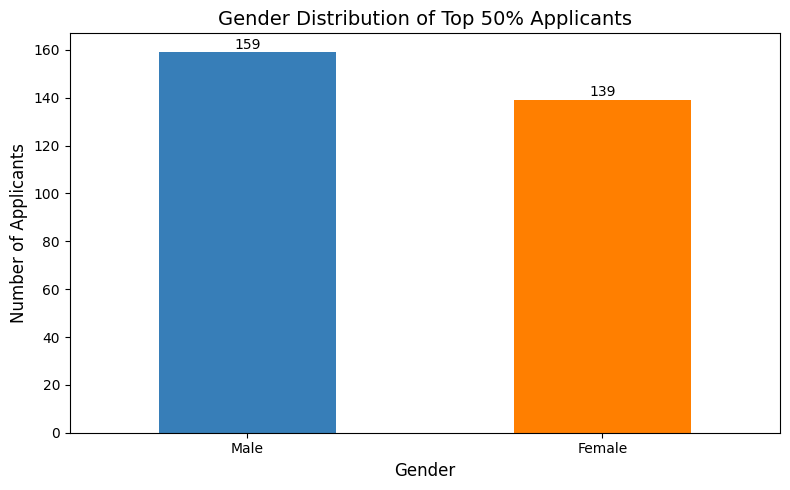

In [61]:
import matplotlib.pyplot as plt

gender_distribution_top_50 = top_50_percent_applicants['gender'].value_counts()

plt.figure(figsize=(8, 5))
gender_distribution_top_50.plot(kind='bar', color=['#377eb8', '#ff7f00'])

plt.title("Gender Distribution of Top 50% Applicants", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)
plt.xticks(rotation=0)

for i, count in enumerate(gender_distribution_top_50):
    plt.text(i, count + (0.01 * gender_distribution_top_50.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Task
Load "rank_resumes_1.csv", "rank_resumes_2.csv", and "rank_resumes_3.csv", filtering each to include only the top 50% of applicants by 'final_score'. Then, create comparative visualizations (e.g., histograms or box plots with legends) for the 'hard_skill_score', 'soft_skill_score', and 'final_score' distributions across these three scenarios, using separate subplots or distinct plots for each score type. Finally, summarize the differences and similarities observed in the score distributions based on these visualizations.

## Prepare Data for Visualization

### Subtask:
Load data from 'rank_resumes_1.csv', 'rank_resumes_2.csv', and 'rank_resumes_3.csv'. For each dataset, filter to include only the top 50% of applicants based on the 'final_score'.


**Reasoning**:
I will load the three specified CSV files into pandas DataFrames and then filter each DataFrame to keep only the top 50% of applicants based on their 'final_score', as requested.



In [62]:
df1 = pd.read_csv("/content/sample_data/rank_resumes_1.csv")
df1_top50 = df1.nlargest(int(0.5 * len(df1)), 'final_score')

df2 = pd.read_csv("/content/sample_data/rank_resumes_2.csv")
df2_top50 = df2.nlargest(int(0.5 * len(df2)), 'final_score')

df3 = pd.read_csv("/content/sample_data/rank_resumes_3.csv")
df3_top50 = df3.nlargest(int(0.5 * len(df3)), 'final_score')

print("Data loaded and filtered for top 50% applicants for df1, df2, and df3.")

Data loaded and filtered for top 50% applicants for df1, df2, and df3.


**Reasoning**:
The subtask of loading and filtering the data is complete. The next step is to visualize the distributions of 'hard_skill_score', 'soft_skill_score', and 'final_score' from the filtered dataframes. To prepare for this, I will add labels to each filtered DataFrame to indicate their origin (original, masculine, feminine) before concatenating them for easier plotting.



In [66]:
df1_top50['scenario'] = 'Original'
df2_top50['scenario'] = 'Masculine-coded'
df3_top50['scenario'] = 'Feminine-coded'

# Concatenate the dataframes for easier plotting
all_top50_df = pd.concat([df1_top50, df2_top50, df3_top50])

print("Scenario labels added and DataFrames concatenated for visualization.")

Scenario labels added and DataFrames concatenated for visualization.


In [67]:
all_top50_df

,candidate_id,hard_required_keyword_raw,hard_preferred_keyword_raw,soft_skill_keyword_raw,hard_required_score,hard_preferred_kw_score,preferred_years_bonus_5plus,hard_preferred_score,hard_skill_score,soft_skill_score,experience_years_norm,experience_jobs_norm,experience_score,final_score,rank_final,Years of Experience,Number of Past Jobs,gender,scenario
0,368,8.0,4.0,1.0,0.888889,0.571429,1.0,0.678571,0.614087,1.0,0.533333,0.3,0.44,0.639044,1,8,3,Female,Original
1,369,8.0,4.0,1.0,0.888889,0.571429,1.0,0.678571,0.614087,1.0,0.533333,0.3,0.44,0.639044,1,8,3,Female,Original
2,370,8.0,4.0,1.0,0.888889,0.571429,1.0,0.678571,0.614087,1.0,0.533333,0.3,0.44,0.639044,1,8,3,Male,Original
3,357,7.0,3.0,1.0,0.777778,0.428571,1.0,0.571429,0.531746,1.0,0.466667,0.4,0.44,0.597873,2,7+,4,Male,Original
4,358,7.0,3.0,1.0,0.777778,0.428571,1.0,0.571429,0.531746,1.0,0.466667,0.4,0.44,0.597873,2,7+,4,Male,Original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,203,5.0,0.0,0.0,0.555556,0.000000,1.0,0.250000,0.340278,0.0,0.466667,0.4,0.44,0.302139,90,7+,4,Male,Feminine-coded
294,446,5.0,0.0,0.0,0.555556,0.000000,1.0,0.250000,0.340278,0.0,0.466667,0.4,0.44,0.302139,90,7,4,Female,Feminine-coded
295,447,5.0,0.0,0.0,0.555556,0.000000,1.0,0.250000,0.340278,0.0,0.466667,0.4,0.44,0.302139,90,7,4,Male,Feminine-coded
296,448,5.0,0.0,0.0,0.555556,0.000000,1.0,0.250000,0.340278,0.0,0.466667,0.4,0.44,0.302139,90,7,4,Female,Feminine-coded


In [69]:
average_keyword_matches = all_top50_df.groupby('scenario')[['hard_required_keyword_raw', 'soft_skill_keyword_raw']].mean()
print("Average keyword matches per scenario:\n", average_keyword_matches)

Average keyword matches per scenario:
                  hard_required_keyword_raw  soft_skill_keyword_raw
scenario                                                          
Feminine-coded                    4.959732                0.959732
Masculine-coded                   5.036913                2.315436
Original                          5.063758                0.130872


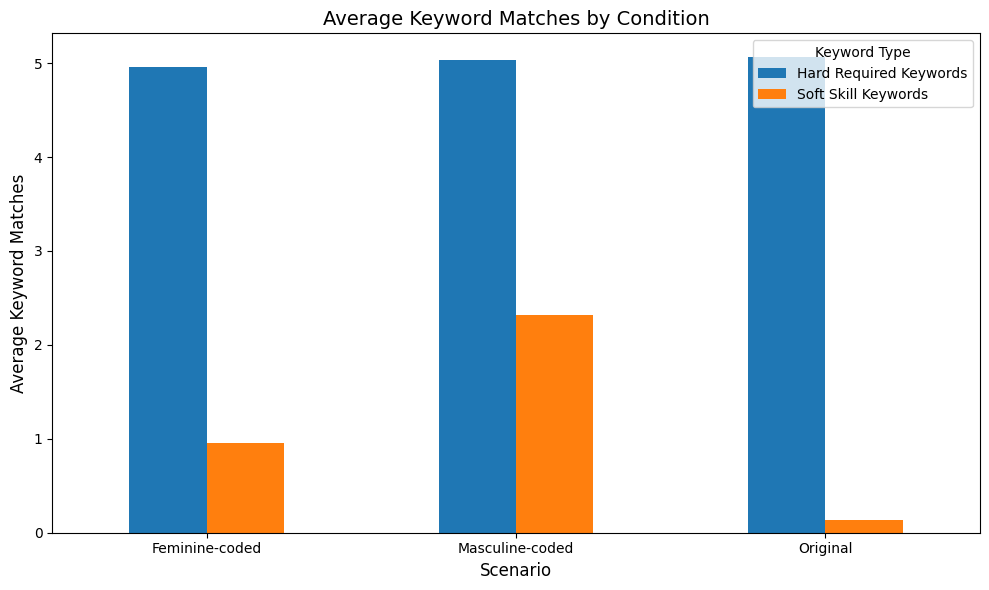

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
average_keyword_matches.plot(kind='bar', ax=ax, rot=0)

ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Average Keyword Matches', fontsize=12)
ax.set_title('Average Keyword Matches by Condition', fontsize=14)
ax.legend(title='Keyword Type', labels=['Hard Required Keywords', 'Soft Skill Keywords'])

plt.tight_layout()
plt.show()
